In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [29]:
'''
Loading the graph with adjacency

graph contains 15 cities in cities.json and all CA DC charging stations from AFDC
'''

graph = src.graph.graph_from_json('Outputs/graph_full.json')
graph = src.routing.edge_types(graph)

In [30]:
'''
Removing non-corridor stations
'''
roadnums = []

for source, node in graph._node.items():
    
    roadnums.append(node['roadnum'])

unique_roadnum, unique_roadnum_count = np.unique(roadnums, return_counts = True)

roadnums_keep = unique_roadnum[(unique_roadnum_count >= 10) & (unique_roadnum != 'nan')]

nodes_keep = []

for source, node in graph._node.items():

    roadnum = node['roadnum']

    if node['type'] == 'city':

        nodes_keep.append(source)
    
    else:

        if roadnum in roadnums_keep:
    
            nodes_keep.append(source)

sng_corridor = src.graph.subgraph(graph, nodes_keep)

In [31]:
roadnums_keep

array(['I10', 'I15', 'I215', 'I405', 'I5', 'I580', 'I80', 'S1', 'S12',
       'S41', 'S60', 'S91', 'S99', 'U101', 'U50'], dtype='<U32')

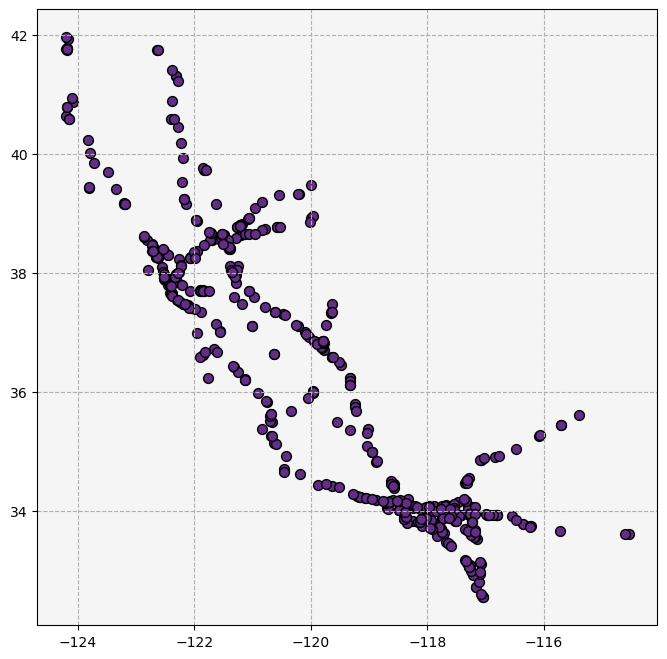

In [32]:
fig, ax = plt.subplots(figsize = (8, 8))

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#622e86',
        'zorder': 1,
        'label': 'Non-Proprietary Stations',
    },
}

src.figures.plot_graph(sng_corridor, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}   

# fig.savefig('Paper/figs/California_SNG_NP.png', bbox_inches = 'tight', dpi = 300)

In [33]:
sng_corridor.number_of_nodes(), sng_corridor.number_of_edges()

(492, 121278)

In [7]:
u, c = np.unique(
    [n.get('network', '') for n in sng_corridor._node.values()], return_counts = True
)

other_networks = u[(c >= 50) & (u != 'Tesla') & (u != 'Non-Networked')]
other_networks = u

In [14]:
'''
Creating Tesla and non-tesla SNGs
'''

tesla = []
other = []
combined = []
rivian = []

for source, node in sng_corridor._node.items():

    if node['type'] == 'city':

        tesla.append(source)
        other.append(source)
        combined.append(source)
        rivian.append(source)

    else:

        include = False

        if node['network'] == 'Tesla':

            tesla.append(source)
            combined.append(source)

        else:

            other.append(source)
            
        if node['network'] in other_networks:

            combined.append(source)

        if node['network'] in ['RIVIAN_ADVENTURE']:

            rivian.append(source)

sng_tesla = src.graph.subgraph(graph, tesla)
sng_other = src.graph.subgraph(graph, other)
sng_combined = src.graph.subgraph(graph, combined)
sng_rivian = src.graph.subgraph(graph, rivian)

In [15]:
sng_combined.number_of_nodes(), sng_tesla.number_of_nodes(), sng_other.number_of_nodes(), sng_rivian.number_of_nodes()

(492, 158, 349, 21)

In [13]:
sng_combined.number_of_nodes() - 15, sng_tesla.number_of_nodes() - 15, sng_other.number_of_nodes() - 15

(477, 143, 334)

In [12]:
src.graph.graph_to_json(sng_combined, 'Outputs/sng_combined.json')
src.graph.graph_to_json(sng_tesla, 'Outputs/sng_tesla.json')
src.graph.graph_to_json(sng_other, 'Outputs/sng_other.json')
src.graph.graph_to_json(sng_tesla_ea, 'Outputs/sng_tesla_ea.json')

In [37]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')

In [38]:
summary_stats = {}

for source, node in graph._node.items():

    network = node.get('network', '')

    if network in summary_stats:

        summary_stats[network]['stations'] += 1
        summary_stats[network]['chargers'] += node.get('n_dcfc', 0)

    else:

        summary_stats[network] = {'stations': 0, 'chargers': 0}

In [39]:
summary_stats_c = {}

for source, node in sng_combined._node.items():

    network = node.get('network', '')

    if network in summary_stats_c:

        summary_stats_c[network]['stations'] += 1
        summary_stats_c[network]['chargers'] += node.get('n_dcfc', 0)

    else:

        summary_stats_c[network] = {'stations': 0, 'chargers': 0}

In [51]:
for key, value in summary_stats.items():

    if key and value['stations'] > 0:

        string = f"\\hline {key} & {value['chargers']} "
        string += f"& {value['stations']} & "
        string += f"{value['chargers'] / value['stations']:.1f} \\\\"
        
        print(string)

\hline Non-Networked & 260 & 123 & 2.1 \\
\hline POWERFLEX & 43 & 11 & 3.9 \\
\hline Blink Network & 30 & 12 & 2.5 \\
\hline SHELL_RECHARGE & 84 & 34 & 2.5 \\
\hline EV Connect & 122 & 47 & 2.6 \\
\hline Tesla & 7093 & 418 & 17.0 \\
\hline EVCS & 299 & 72 & 4.2 \\
\hline Electrify America & 1152 & 243 & 4.7 \\
\hline ChargePoint Network & 417 & 265 & 1.6 \\
\hline Volta & 20 & 17 & 1.2 \\
\hline EVGATEWAY & 118 & 22 & 5.4 \\
\hline BP_PULSE & 49 & 14 & 3.5 \\
\hline eVgo Network & 1367 & 339 & 4.0 \\
\hline EVRANGE & 22 & 7 & 3.1 \\
\hline RIVIAN_ADVENTURE & 30 & 15 & 2.0 \\
\hline CHARGELAB & 1 & 1 & 1.0 \\
\hline 7CHARGE & 25 & 8 & 3.1 \\
\hline CIRCLE_K & 28 & 6 & 4.7 \\
\hline LOOP & 13 & 5 & 2.6 \\
\hline CHARGENET & 12 & 2 & 6.0 \\
\hline NOODOE & 6 & 3 & 2.0 \\


In [52]:
for key, value in summary_stats_c.items():

    if key and value['stations'] > 0:

        string = f"\\hline {key} & {value['chargers']} "
        string += f"& {value['stations']} & "
        string += f"{value['chargers'] / value['stations']:.1f} \\\\"
        
        print(string)

\hline Non-Networked & 258 & 50 & 5.2 \\
\hline Tesla & 2471 & 142 & 17.4 \\
\hline Electrify America & 468 & 68 & 6.9 \\
\hline EV Connect & 66 & 19 & 3.5 \\
\hline ChargePoint Network & 188 & 80 & 2.4 \\
\hline EVCS & 37 & 11 & 3.4 \\
\hline SHELL_RECHARGE & 41 & 11 & 3.7 \\
\hline EVGATEWAY & 19 & 4 & 4.8 \\
\hline BP_PULSE & 3 & 2 & 1.5 \\
\hline eVgo Network & 311 & 58 & 5.4 \\
\hline Blink Network & 1 & 1 & 1.0 \\
\hline EVRANGE & 3 & 1 & 3.0 \\
\hline RIVIAN_ADVENTURE & 10 & 5 & 2.0 \\
\hline CIRCLE_K & 12 & 2 & 6.0 \\
\hline 7CHARGE & 4 & 1 & 4.0 \\
\hline LOOP & 2 & 1 & 2.0 \\


In [80]:
graph = src.graph.subgraph(
    sng_combined,
    [k for k, v in sng_combined._node.items() if v['type'] == 'station']
)

In [81]:
un, unc = np.unique(
    [n.get('network', 'none') for n in graph._node.values()],
    return_counts = True,
)

In [82]:
un, unc

(array(['7CHARGE', 'BP_PULSE', 'Blink Network', 'CHARGENET', 'CIRCLE_K',
        'ChargePoint Network', 'EV Connect', 'EVCS', 'EVGATEWAY',
        'EVRANGE', 'Electrify America', 'FLO', 'LOOP', 'NOODOE',
        'Non-Networked', 'POWERFLEX', 'RIVIAN_ADVENTURE', 'SHELL_RECHARGE',
        'Tesla', 'Volta', 'eVgo Network'], dtype='<U19'),
 array([  2,   3,   2,   1,   3,  81,  20,  12,   5,   2,  69,   1,   2,
          1,  51,   1,   6,  12, 143,   1,  59]))

In [83]:
indices = np.flip(np.argsort(unc))
unc = unc[indices]
un = un[indices]

In [98]:
combinations = [[n] for idx, n in enumerate(un) if unc[idx] > 20]
combinations.append([n for idx, n in enumerate(un) if unc[idx] <= 20])

In [99]:
labels = [c[0] for c in combinations]
labels[-1] = 'Other Networks'

In [100]:
subgraphs = {}

for idx, label in enumerate(labels):

    comb = combinations[idx]

    nodes = [k for k, v in graph._node.items() if v.get('network', '') in comb]

    subgraphs[label] = src.graph.subgraph(graph, nodes)

In [101]:
combinations

[['Tesla'],
 ['ChargePoint Network'],
 ['Electrify America'],
 ['eVgo Network'],
 ['Non-Networked'],
 ['EV Connect',
  'EVCS',
  'SHELL_RECHARGE',
  'RIVIAN_ADVENTURE',
  'EVGATEWAY',
  'CIRCLE_K',
  'BP_PULSE',
  'EVRANGE',
  'LOOP',
  'Blink Network',
  '7CHARGE',
  'Volta',
  'POWERFLEX',
  'FLO',
  'NOODOE',
  'CHARGENET']]

In [102]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    print(combination)

    x_i, n_i, h_i = src.analysis.redundancy_in_station(subgraphs[labels[idx]])
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

['Tesla']
['ChargePoint Network']
['Electrify America']
['eVgo Network']
['Non-Networked']
['EV Connect', 'EVCS', 'SHELL_RECHARGE', 'RIVIAN_ADVENTURE', 'EVGATEWAY', 'CIRCLE_K', 'BP_PULSE', 'EVRANGE', 'LOOP', 'Blink Network', '7CHARGE', 'Volta', 'POWERFLEX', 'FLO', 'NOODOE', 'CHARGENET']


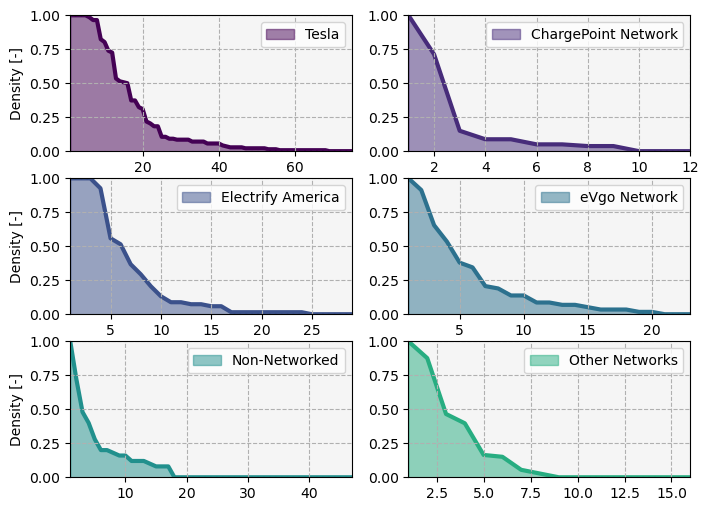

In [105]:
m = 8
rows = 3
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (4 * columns, 2 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend()

        idx += 1

fig.savefig('Paper/figs/California_RIS_SF_Corridor.png', bbox_inches = 'tight', dpi = 300)